# Image classification

## Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Activation, MaxPooling2D, Flatten, Dropout, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorboard.plugins.hparams import api as hp

import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib import Path, PureWindowsPath

start_time = datetime.datetime.now()

## Load data

In [2]:
# SET DIR DATASET AND IMAGE TRAIN DIR# SET DIR DATASET AND IMAGE TRAIN DIR
import sys

if sys.platform.startswith('darwin'):
    DataSet = '/Volumes/Dati/DL_Dataset/'     
    PathImg = 'VOCdevkit/VOC2012/ImgForClass_Reduce/'    
    # 'Intel_Image-Classification/seg_train/' ; '' ; 'VOCdevkit/VOC2012/ImgForClass_Reduce/'
    
elif sys.platform.startswith('linux'):
    DataSet = '/content/drive/My Drive/DataSets/'     
    PathImg = 'VOCdevkit/VOC2012/ImgForClass_Reduce/'
    
elif sys.platform.startswith('win'):
    DataSet = 'E:\\'     
    PathImg = 'PROVA_VOC\\ImgForClass_TrainVal\\' 
    # 'Intel_Image-Classification\\seg_train\\' ; 'coco-animals\\' ; 'VOCdevkit\\VOC2012\\ImgForClass_Reduce\\'
    
else:
    print('altro')
    
# DIR CON LE IMAMGINI DI TRAIN
train_dir = DataSet + PathImg
# validation_dir = os.path.join(PATH, 'VAL')

NET = 'AlexNet'      # or 'VGG16' ; 'AlexNet'
SETname = 'VOC2012'    # or 'Intel' ; 'coco-animals' ; 'VOC2012'

PATH_log = os.path.join(DataSet, 'Logs', NET, SETname)

if not os.path.exists(PATH_log):
            os.makedirs(PATH_log)
        
dateTime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
LogsDir = os.path.join(PATH_log, dateTime)

print('PATh log = ', PATH_log)
print('LogsDir = ', LogsDir)
print(os.path.dirname(PATH_log))
                                

PATh log =  E:\Logs\AlexNet\VOC2012
LogsDir =  E:\Logs\AlexNet\VOC2012\20200820-140833
E:\Logs\AlexNet


The dataset has the following directory structure:

<pre>
<b>ImgForClass(PascalVOC2012)</b>
|__ <b>Train-Set</b>
    |______ <b>Class-1</b>: [2008_000033.jpg, 2008_000037.jpg, 2008_000151.jpg ....]
    |______ <b>Class-2</b>: [2008_000036.jpg, 2008_000191.jpg, 2008_000196.jpg ...]
    |______ <b>Class-3</b>: [2008_000095.jpg, 2008_000097.jpg, 2008_000103.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
|__ <b>Val-set</b>
    |______ <b>Class-1</b>: [2008_000021.jpg, 2008_000064.jpg, 2008_000251.jpg ....]
    |______ <b>Class-2</b>: [2008_000090.jpg, 2008_000133.jpg, 2008_000194.jpg ...]
    |______ <b>Class-3</b>: [2008_000054.jpg, 2008_000123.jpg, 2008_000134.jpg ...]
    |______ <b>....</b>: [xxxx_xxxxxx.jpg, ...]
</pre>

### Understand the data

Let's look at how many class and images are in the training and validation sets:

In [3]:
total_train = 0
# total_validation = 0

classIMG = [x for x in os.listdir( train_dir )]  
print(classIMG)

for x in classIMG:
    if x != '.DS_Store':

        os.path.join(train_dir, x)
        #os.path.join(validation_dir, x)

        num_x_train = len(os.listdir(os.path.join(train_dir, x)))
        total_train += num_x_train
        print('total training %s images: %d' % (x, num_x_train))

        # num_x_validation = len(os.listdir(os.path.join(validation_dir, x)))
        # total_validation += num_x_validation
        # print('total validation %s images: %d' % (x, num_x_validation))

print("----------")
print("Total training images:", total_train)
# print("Total validation images:", total_validation)

['bird', 'cat', 'dog', 'person']
total training bird images: 650
total training cat images: 650
total training dog images: 650
total training person images: 650
----------
Total training images: 2600


#### COSTANTI 
For convenience, set up variables to use while pre-processing the dataset and training the network.

In [4]:
batch_size = 16
epochs = 200
IMG_HEIGHT = 227
IMG_WIDTH = 227

L1 = 0.
L2 = 0.01

Adam = tf.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt = SGD

IMAGE_MEAN = [101.39, 111.88, 117.52]
IMAGE_STD = [58.20, 57.18, 58.26]

## Data preparation

In [5]:
def std_set(image):
    image = np.array(image)
    image-= IMAGE_MEAN
    image/=IMAGE_STD
    return image

In [6]:
train_image_generator = ImageDataGenerator(#preprocessing_function = std_set,
                                            validation_split=0.3, 
                                            rescale=1./255
                                           )
                                          #featurewise_center=True,
                                          #featurewise_std_normalization=True) # Generator for our training data
#validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           subset='training')
class_dict = train_data_gen.class_indices
print(train_data_gen.class_indices, len(class_dict))
print('media del batch : ', train_data_gen[0][0].mean())
print('deviazione standard del batch : ', train_data_gen[0][0].std())

Found 1820 images belonging to 4 classes.
{'bird': 0, 'cat': 1, 'dog': 2, 'person': 3} 4
media del batch :  0.43492424
deviazione standard del batch :  0.29470518


In [8]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              subset='validation')


Found 780 images belonging to 4 classes.


### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [9]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. 

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, label in zip( images_arr, axes, labels):
        ax.imshow(img)
        ax.axis('on')
        title = list(class_dict.keys())[list(class_dict.values()).index(np.argmax(label))]
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

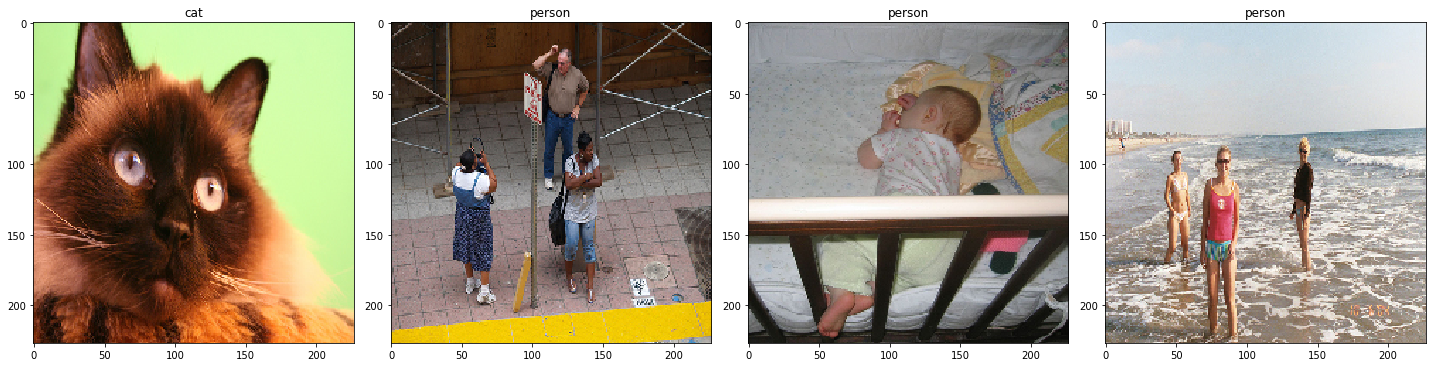

In [11]:
plotImages(sample_training_images[:4], labels[:4])

### Create "Callbacks" for Tensorboard monitor 

In [12]:
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 9),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'VOC_'+dateTime+'_model.h5'), 
                                       monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### REGOLARIZZAZIONE

In [13]:
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(0., dtype=float32), 'l2': array(0.01, dtype=float32)}

## Create the model

The model consists of ... AlexNet

In [14]:
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid', 
                 activation='relu', kernel_regularizer=reg, name = 'conv1'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name = 'pool1'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', 
                 activation='relu', kernel_regularizer=reg, name = 'conv2'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name ='pool2'))

# 3rd Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation='relu', kernel_regularizer=reg, name = 'conv3'))

# 4th Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation= 'relu', kernel_regularizer=reg, name = 'conv4'))

# 5th Convolutional Layer
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation= 'relu', kernel_regularizer=reg, name = 'conv5'))
# Max Pooling
#model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', name = 'pool5'))

# ADD layers Zhou
'''model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', 
                 activation="relu", kernel_regularizer=reg, name = 'conv6'))'''

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="valid", 
                 activation="relu", kernel_regularizer=reg, name = 'conv6'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="valid", 
                 activation="relu", kernel_regularizer=reg, name = 'conv7'))
model.add(GlobalAveragePooling2D(name = 'GAP'))
model.add(Dense(units=len(class_dict), activation="softmax"))

In [15]:
"""
model = Sequential()
model.add(Model(inputs=model_base.input, outputs=model_base.get_layer('conv5').output))

model.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same", 
                 activation="relu", kernel_regularizer=reg))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=len(class_dict), activation="softmax"))
"""

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 384)       0

### Compile the model

In [16]:
model.compile(optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

opt.__dict__

{'_use_locking': True,
 '_name': 'SGD',
 '_hyper': {'learning_rate': 0.01, 'decay': 1e-06, 'momentum': 0.9},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 1e-06,
 '_hypers_created': False,
 '_momentum': True,
 'nesterov': True,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Model summary

View all the layers of the network using the model's `summary` method:

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 55, 55, 96)        34944     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 27, 27, 96)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 27, 27, 256)       614656    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 13, 256)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 13, 13, 384)       885120    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 15, 15, 384)       0

### Train the model

Use the 'fit' (`fit_generator`) method of the `ImageDataGenerator` class to train the network.

In [18]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)
for key in history.history:
    print(key)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 48 steps
Epoch 1/200
112/113 [============================>.] - ETA: 0s - loss: 17.9474 - accuracy: 0.2416
Epoch 00001: val_accuracy improved from -inf to 0.24870, saving model to E:\Logs\AlexNet\VOC2012\VOC_20200820-140833_model.h5
113/113 [==============================] - 45s 401ms/step - loss: 17.9168 - accuracy: 0.2422 - val_loss: 14.4256 - val_accuracy: 0.2487
Epoch 2/200
112/113 [============================>.] - ETA: 0s - loss: 11.8805 - accuracy: 0.2472
Epoch 00002: val_accuracy improved from 0.24870 to 0.25130, saving model to E:\Logs\AlexNet\VOC2012\VOC_20200820-140833_model.h5
113/113 [==============================] - 33s 294ms/step - loss: 11.8609 - accuracy: 0.2472 - val_loss: 9.6191 - val_accuracy: 0.2513
Epoch 3/200
112/113 [============================>.] - ETA: 0s - loss: 8.0128 - accuracy: 0.2327
Epoch 00003: val_accuracy did not improve from 0.25130
113/113 [========================

### Visualize training results

Now visualize the results after training the network.

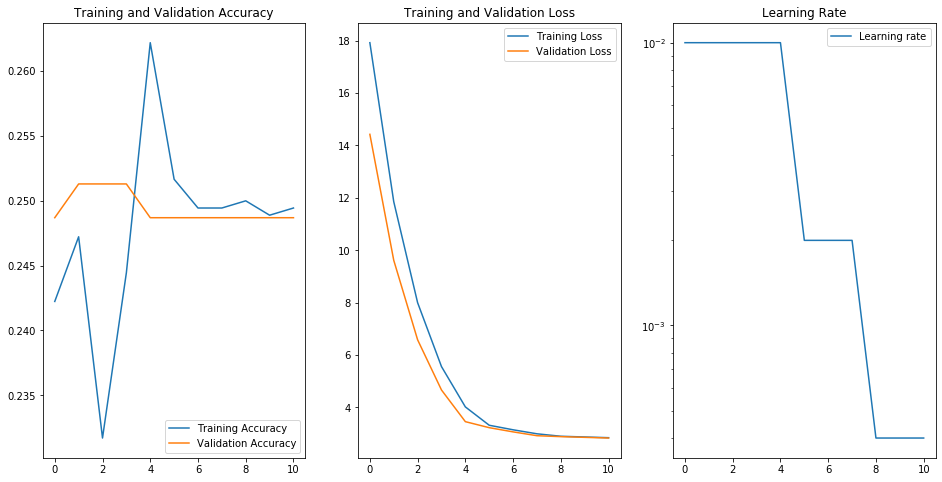

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.tight_layout(pad=3.0)
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Learning Rate')

plt.show()

In [20]:
end_time = datetime.datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:06:20.395040


## Data augmentation

In [21]:
start_time = datetime.datetime.now()

LogsDir = os.path.join(PATH_log, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 

callbacks_list_2 = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 9),
    tf.keras.callbacks.ModelCheckpoint(filepath =os.path.join(PATH_log, 'VOC2_'+dateTime+'_model_2.h5'), 
                                       monitor = 'val_accuracy', save_best_only = True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3),
    tf.keras.callbacks.TensorBoard(log_dir = LogsDir, histogram_freq = 1, embeddings_freq = 1)
]

#### COSTANTI

In [22]:
#L1 = 0.0001
L2 = 0.01

Adam = tf.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False, name='Adam')
RMSprop = tf.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
SGD = tf.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, name='SGD')

opt = SGD

### Augment and visualize data

In [23]:
image_gen_train = ImageDataGenerator(
                    preprocessing_function = std_set,
                    #rescale=1./255,
                    #featurewise_center=True,
                    #featurewise_std_normalization=True,
                    rotation_range=45,
                    #width_shift_range=.15,
                    #height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    validation_split=0.3                    
                    )

In [24]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical',
                                                     subset='training')

class_dict = train_data_gen.class_indices

Found 1820 images belonging to 4 classes.


Visualize how a single image would look five different times when passing these augmentations randomly to the dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


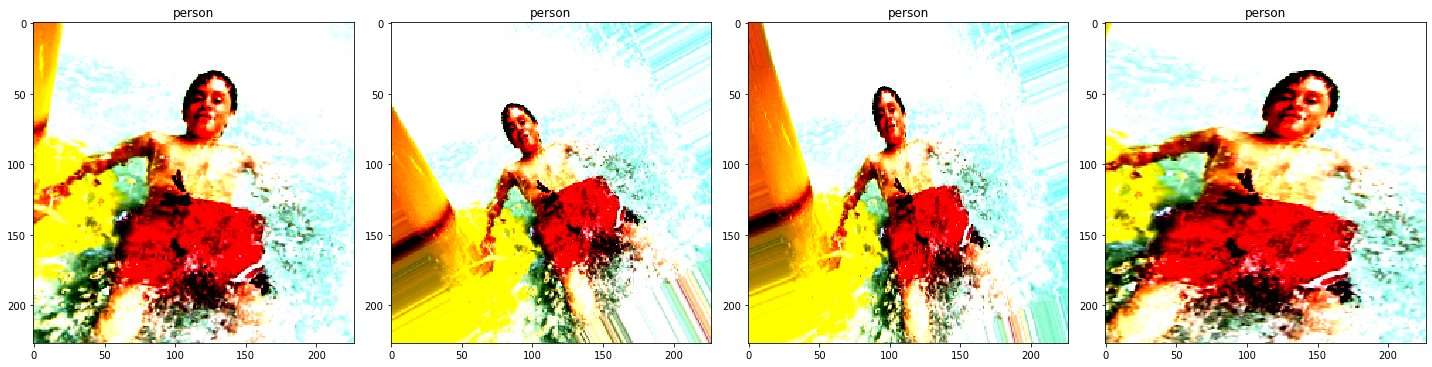

In [25]:
augmented_images, labels = [train_data_gen[0][0][0] for i in range(5)], [train_data_gen[0][1] for i in range(5)]
plotImages(augmented_images, labels)

### Create validation data generator

Generally, only apply data augmentation to the training examples. In this case, only rescale the validation images and convert them into batches using `ImageDataGenerator`.

In [26]:
# image_gen_val = ImageDataGenerator(rescale=1./255)

In [27]:
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                 directory=train_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical',
                                                 subset='validation')

Found 780 images belonging to 4 classes.


#### REGOLARIZZAZIONE

In [28]:
import tensorflow as tf
reg = tf.keras.regularizers.L1L2(l1=L1, l2=L2)

reg.__dict__

{'l1': array(0., dtype=float32), 'l2': array(0.01, dtype=float32)}

## Dropout

## Creating a new network with Dropouts

In [29]:
model_new = Sequential()

# 1st Convolutional Layer
model_new.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(224,224,3), kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.2))

# Max Pooling 1
model_new.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model_new.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.3))

# Max Pooling 2
model_new.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same'))

# 3rd Convolutional Layer
model_new.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
# model_new.add(Dropout(0.35))


# 4th Convolutional Layer
model_new.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.35))

# 5th Convolutional Layer
model_new.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.3))

# ADD layers Zhou
model_new.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', activation="relu", kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.4))

model_new.add(Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding="same", activation="relu", kernel_regularizer=reg))

# Add Dropout to prevent overfitting
model_new.add(Dropout(0.5))

model_new.add(GlobalAveragePooling2D())
model_new.add(Dense(units=len(class_dict), activation="softmax"))

In [30]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 384)      

### Compile the model

After introducing dropouts to the network, compile the model and view the layers summary.

In [31]:
model_new.compile(optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

opt.__dict__

{'_use_locking': True,
 '_name': 'SGD',
 '_hyper': {'learning_rate': 0.01, 'decay': 1e-06, 'momentum': 0.9},
 '_slots': {},
 '_slot_names': [],
 '_weights': [],
 '_iterations': None,
 '_deferred_slot_restorations': {},
 '_initial_decay': 1e-06,
 '_hypers_created': False,
 '_momentum': True,
 'nesterov': True,
 '_self_setattr_tracking': True,
 '_self_unconditional_checkpoint_dependencies': [],
 '_self_unconditional_dependency_names': {},
 '_self_unconditional_deferred_dependencies': {},
 '_self_update_uid': -1,
 '_self_name_based_restores': set()}

### Train the model

After successfully introducing data augmentations to the training examples and adding dropouts to the network, train this new network:

In [32]:
history = model_new.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    callbacks = callbacks_list_2,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 48 steps
Epoch 1/200
112/113 [============================>.] - ETA: 0s - loss: 19.3711 - accuracy: 0.2858
Epoch 00001: val_accuracy improved from -inf to 0.27865, saving model to E:\Logs\AlexNet\VOC2012\VOC2_20200820-140833_model_2.h5
113/113 [==============================] - 57s 508ms/step - loss: 19.3374 - accuracy: 0.2866 - val_loss: 15.5390 - val_accuracy: 0.2786
Epoch 2/200
112/113 [============================>.] - ETA: 0s - loss: 12.7634 - accuracy: 0.3082
Epoch 00002: val_accuracy improved from 0.27865 to 0.35938, saving model to E:\Logs\AlexNet\VOC2012\VOC2_20200820-140833_model_2.h5
113/113 [==============================] - 47s 414ms/step - loss: 12.7420 - accuracy: 0.3076 - val_loss: 10.2906 - val_accuracy: 0.3594
Epoch 3/200
112/113 [============================>.] - ETA: 0s - loss: 8.5603 - accuracy: 0.3233
Epoch 00003: val_accuracy did not improve from 0.35938
113/113 [=================

UnknownError: Failed to WriteFile: E:\Logs\AlexNet\VOC2012\20200820-141453\train\keras_embedding.ckpt-15_temp_875a3d1d6d60466f961d28c8d127233b/part-00001-of-00002.data-00000-of-00001.tempstate16582509716340990085 : Spazio su disco insufficiente.
; Unknown error [Op:SaveV2]

### Visualize the model

Visualize the new model after training, you can see that there is significantly less overfitting than before. The accuracy should go up after training the model for more epochs.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

lr=history.history['lr']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr, label='Learning rate')
plt.yscale('log')
plt.legend(loc='upper right')
plt.title('Learning Rate')
plt.show()

In [ ]:
end_time = datetime.datetime.now()
print('Duration: {}'.format(end_time - start_time))